Step 1) Add stints

Step 2) Remove fuel, create fuel corrected laps 

Step 3) Remove laps 5% outside fastest

Step 4) Normalise by taking away fastest lap

Step 5) Curves on normalised laps (try number of total laps (practice + quali inc.) and try number of laps since fitting)


\
\
2 other ideas:

1) For each stint do its own curve then average the curves

2) Average out the normalised laptimes for the same lap, so say average all the lap 1 times and then curve from that

\
\
Need to test if actually better using individual drivers or just to average over all drivers. Test with a whole season

In [165]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from DB.models import init_db, Circuit, Season, RacingWeekend, Driver, Session, SessionResult, Lap


def create_dataframe():
	# Initialize db connection and session
	db_engine, db_session = init_db()

	# Query data from the database
	query = db_session.query(
		RacingWeekend.year,
		RacingWeekend.round,
		Circuit.circuit_name,
		Driver.driver_name,
		Driver.driver_short,
		Lap.lap_num,
		Lap.lap_time,
		Lap.tyre,
		Lap.tyre_laps,
		Lap.pit,
		Session.session_type
	).join(RacingWeekend.circuit) \
	 .join(RacingWeekend.sessions) \
	 .join(Session.laps) \
	 .join(Lap.driver) \
	 .join(RacingWeekend.season) \
	 .all()

	# Convert result to list of dicts
	data = []
	for row in query:
		data.append({
			'year': row.year,
			'round': row.round,
			'circuit_name': row.circuit_name,
			'driver_name': row.driver_name,
			'driver_short': row.driver_short,
			'lap_num': row.lap_num,
			'lap_time': row.lap_time,
			'tyre': row.tyre,
			'tyre_laps': row.tyre_laps,
			'pit': row.pit,
			'session_type': row.session_type
		})

	# Create DataFrame
	df = pd.DataFrame(data)
	return df
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Auto-detect the display width
pd.set_option('display.max_colwidth', None)  # Display full content of each column

df = create_dataframe()
df = df[(df['year'] == 2022) & (df['round'] == 1)]

## Step 1) Add stints 

In [166]:
def assign_stint_numbers(df):
	# Assign stint numbers to laps based on pit stops for each driver
	df['stint'] = np.nan
	for driver in df['driver_short'].unique():
		driver_data = df[df['driver_short'] == driver]
		stint_number = 1
		for i in driver_data.index:
			if driver_data.loc[i, 'pit'] and i != driver_data.index[0]:
				stint_number += 1
			df.loc[i, 'stint'] = stint_number
	df['stint'] = df['stint'].astype(int)
	return df


df = assign_stint_numbers(df[df['session_type'] == 'Race'])

/tmp/ipykernel_14389/219913496.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stint'] = np.nan
/tmp/ipykernel_14389/219913496.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stint'] = df['stint'].astype(int)


## Step 2) Fuel corrected laptime

In [167]:
def correct_fuel_effect(df, max_fuel_kg=110, fuel_effect_per_kg=0.03):
	# Find the maximum number of laps completed by any driver in the race
	max_laps_race = df['lap_num'].max()

	# Group by driver to process each driver's laps individually
	def _correct_fuel_for_driver(driver_df):
		driver_df['fuel_weight'] = max_fuel_kg - (driver_df['lap_num'] - 1) * (max_fuel_kg / max_laps_race)
		driver_df['fuel_correction'] = driver_df['fuel_weight'] * fuel_effect_per_kg
		driver_df['fuel_corrected_lap_time'] = driver_df['lap_time'] - driver_df['fuel_correction']
		return driver_df

	# Apply the correction to each driver's laps
	df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
	return df

df = correct_fuel_effect(df)

/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)


## Step 3) Remove laps not within 5% of fastest

In [168]:
def remove_laps_outside_percent(df, percentage=5):
	"""
	Remove laps that are not within the specified percentage of the fastest lap time for each driver.

	Parameters:
		df (pd.DataFrame): The DataFrame containing lap data for the full race.
		percentage (float): The percentage threshold (default: 5%).

	Returns:
		pd.DataFrame: DataFrame with laps not within the specified percentage of the fastest lap time removed for each driver.
	"""
	# Group by driver and apply the filtering logic to each driver's laps
	def _filter_driver_laps(driver_df):
		# Calculate the threshold based on the fastest lap time for the driver
		fastest_lap_time = driver_df['fuel_corrected_lap_time'].min()
		threshold = fastest_lap_time * (1 + percentage / 100)

		# Remove laps not within the specified percentage of the fastest lap time
		driver_df = driver_df[driver_df['fuel_corrected_lap_time'] <= threshold]

		return driver_df

	# Apply the filtering logic to each driver's laps
	df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)

	return df

df = remove_laps_outside_percent(df)

/tmp/ipykernel_14389/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


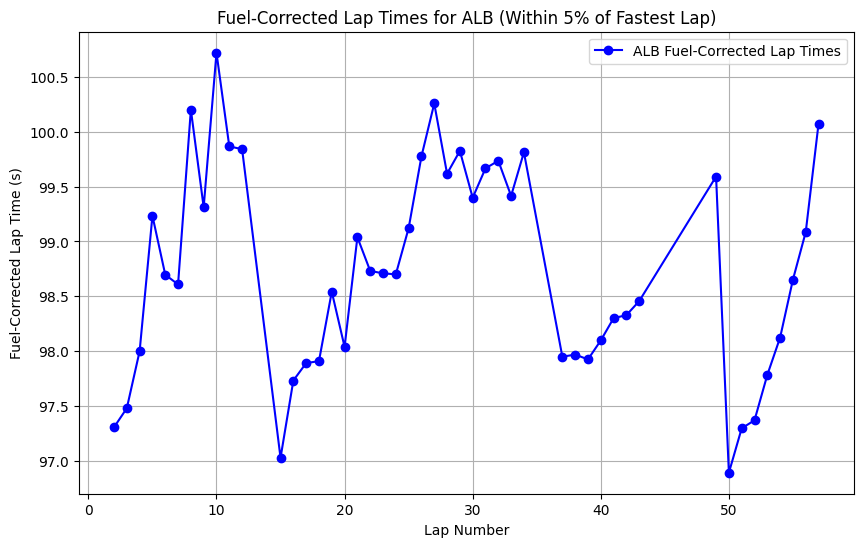

In [169]:
import matplotlib.pyplot as plt

# Filter the DataFrame for the specific driver (e.g., 'ALB')
df_alb = df[df['driver_short'] == 'ALB']

# Plotting
plt.figure(figsize=(10, 6))

# Plot fuel-corrected lap times for ALB
plt.plot(df_alb['lap_num'], df_alb['fuel_corrected_lap_time'], 
		 label='ALB Fuel-Corrected Lap Times', marker='o', linestyle='-', color='blue')

# Add labels and title
plt.xlabel('Lap Number')
plt.ylabel('Fuel-Corrected Lap Time (s)')
plt.title(f"Fuel-Corrected Lap Times for ALB (Within {5}% of Fastest Lap)")
plt.legend()
plt.grid(True)
plt.show()

## Step 4) Normalise by taking away fastest lap for driver

In [170]:
def normalise_lap_times(df):
	# Group by driver and calculate the fastest lap time for each driver
	df['fastest_lap_time'] = df.groupby('driver_short')['fuel_corrected_lap_time'].transform('min')

	# Normalise lap times by subtracting the fastest lap time
	df['normalised_lap_time'] = df['fuel_corrected_lap_time'] - df['fastest_lap_time']

	# Drop the fastest_lap_time as it's no longer needed
	df = df.drop(columns=['fastest_lap_time'])

	return df

df = normalise_lap_times(df)

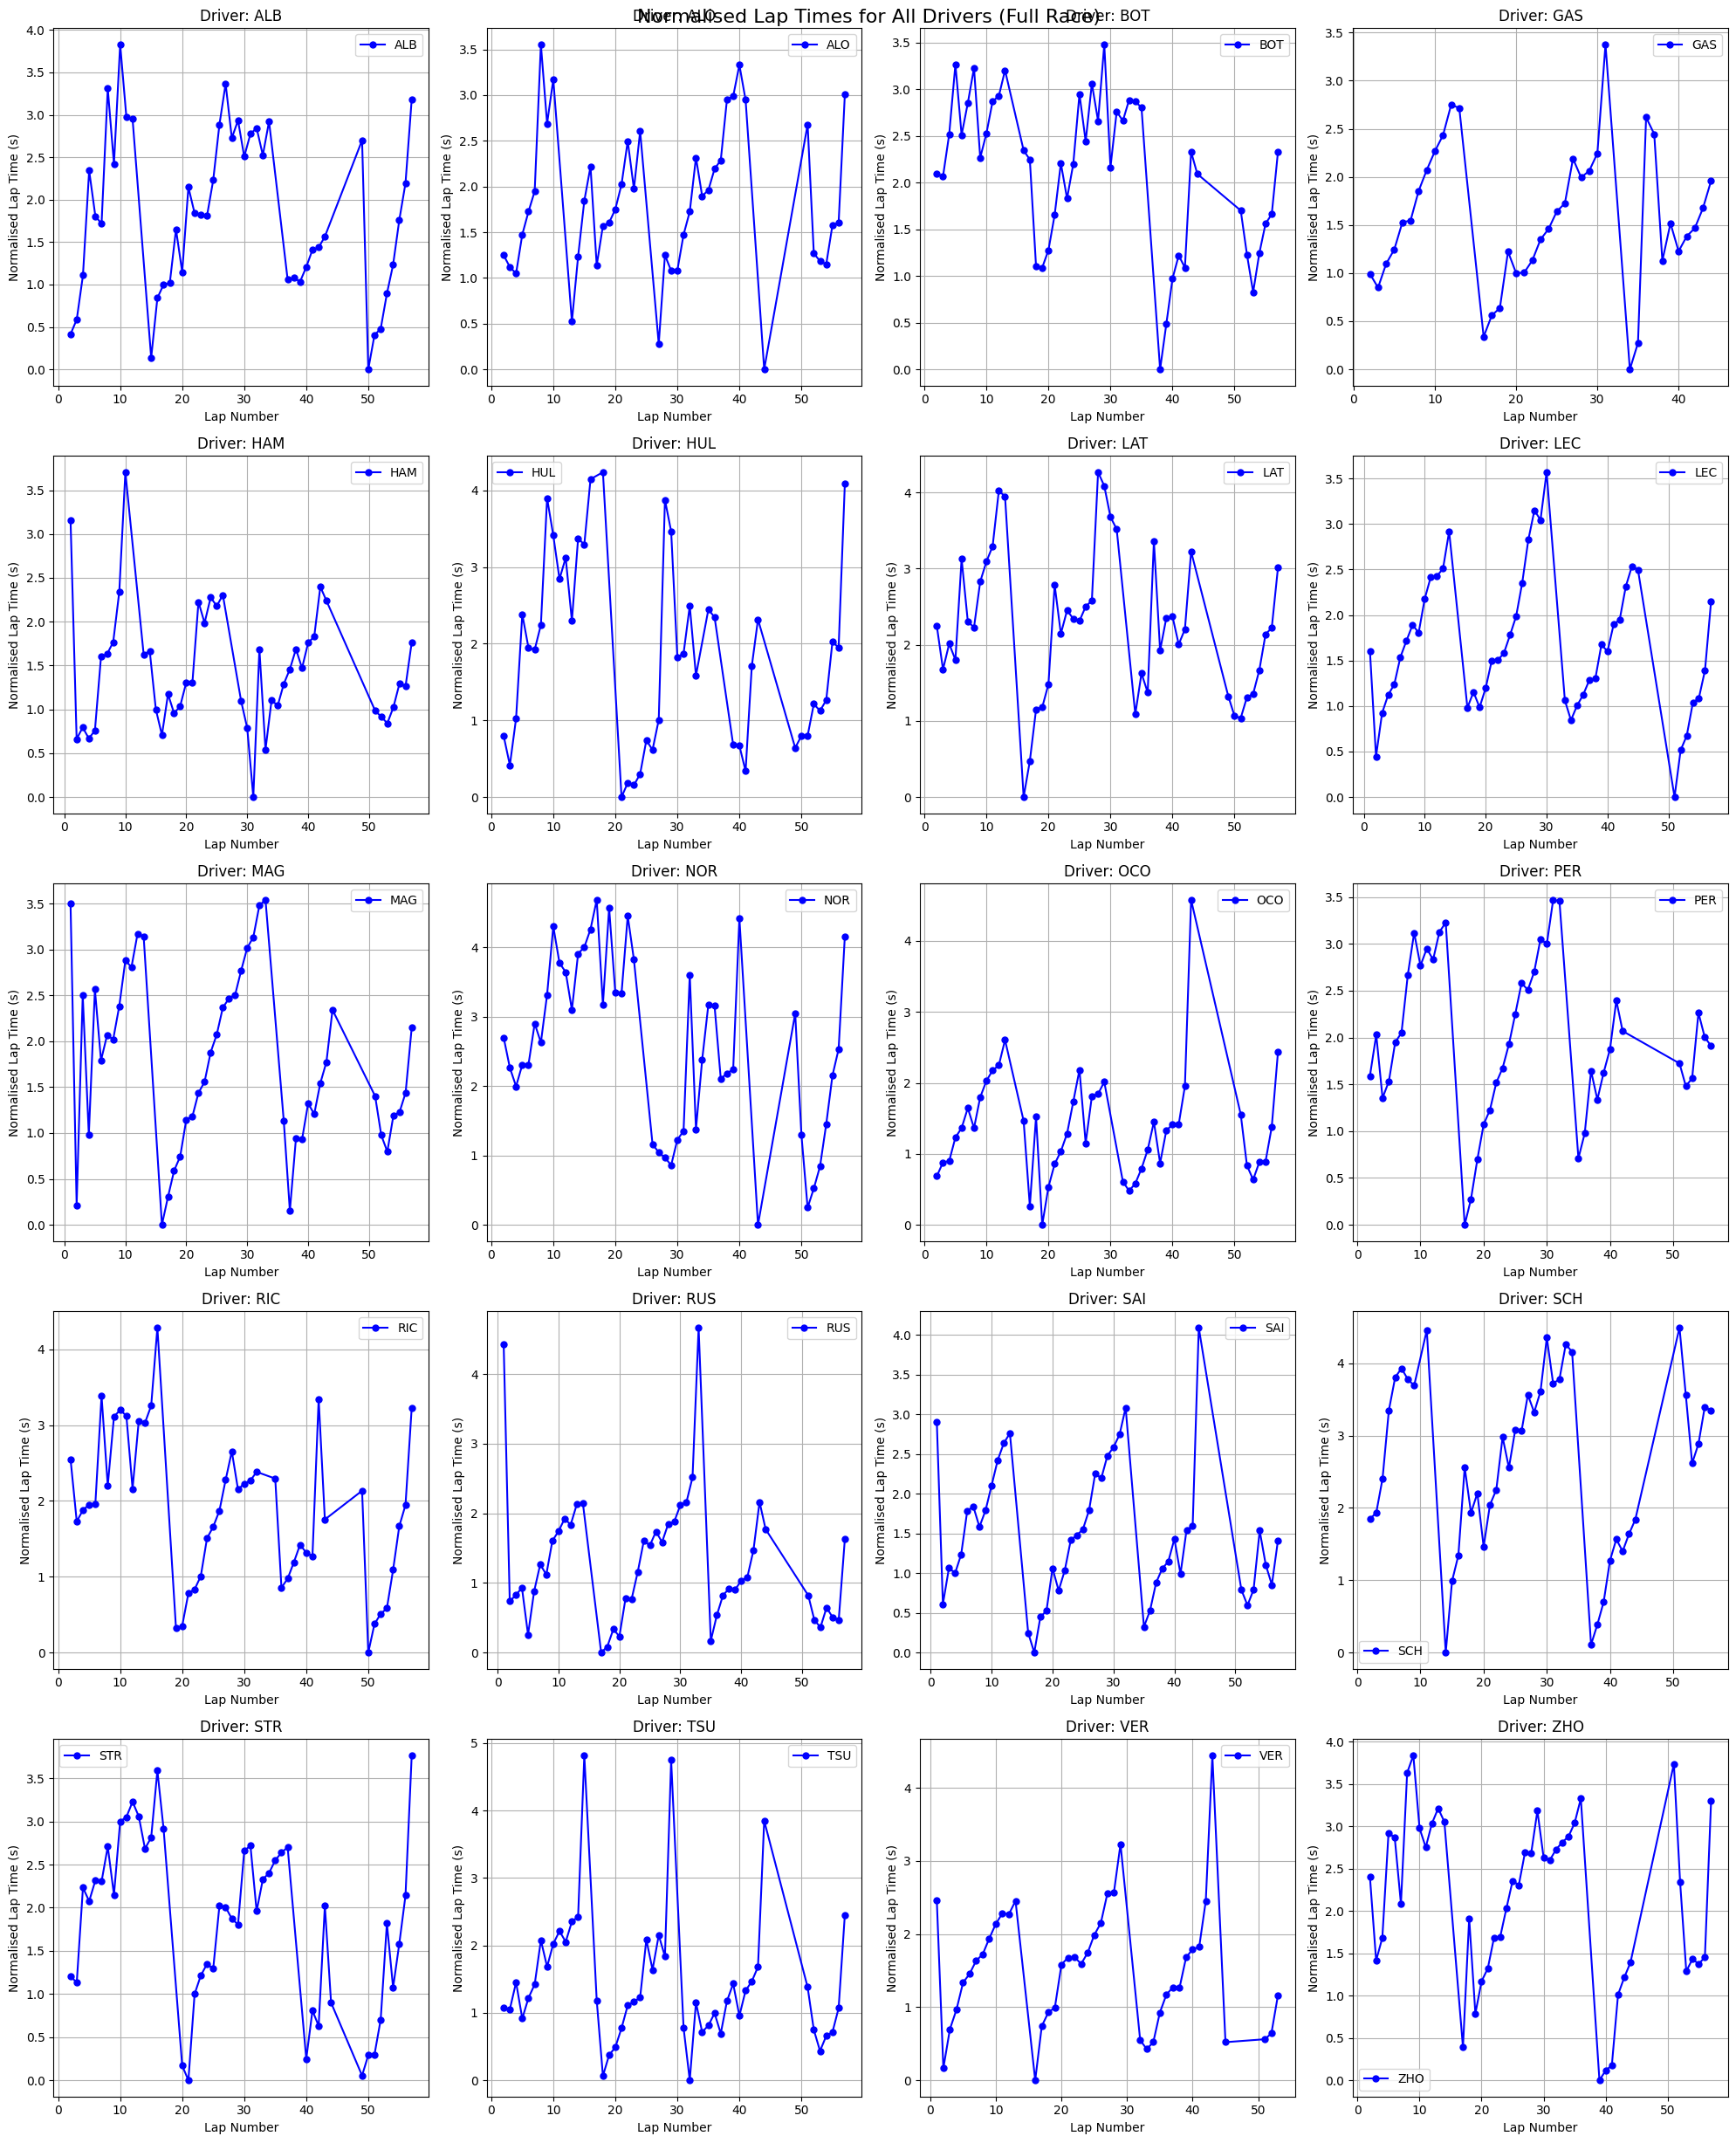

In [171]:
import matplotlib.pyplot as plt

# Normalise lap times
df = normalise_lap_times(df)

# Get the list of all drivers
drivers = df['driver_short'].unique()

# Calculate the number of rows and columns for the grid
num_drivers = len(drivers)
num_cols = 4  # Number of columns in the grid
num_rows = (num_drivers + num_cols - 1) // num_cols  # Calculate rows needed

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
fig.suptitle('Normalised Lap Times for All Drivers (Full Race)', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot Normalised lap times for each driver
for i, driver in enumerate(drivers):
	driver_data = df[df['driver_short'] == driver]
	ax = axes[i]
	ax.plot(driver_data['lap_num'], driver_data['normalised_lap_time'], 
			label=driver, marker='o', linestyle='-', markersize=5, color='blue')
	ax.set_xlabel('Lap Number')
	ax.set_ylabel('Normalised Lap Time (s)')
	ax.set_title(f'Driver: {driver}')
	ax.grid(True)
	ax.legend()

# Hide unused subplots
for j in range(i + 1, num_rows * num_cols):
	axes[j].axis('off')

plt.tight_layout()
plt.show()

## Step 5) Curves

In [172]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def calculate_tyre_degradation_curves(df):
	"""
	Calculate polynomial curves (degree 2) for tyre degradation for each driver in the race.
	Only uses stints with at least 6 laps for Tyre Type 1, 12 laps for Tyre Type 2, and 20 laps for Tyre Type 3.

	Parameters:
		df (pd.DataFrame): The DataFrame containing lap data for the full race.

	Returns:
		dict: A nested dictionary where:
			  - Key 1: Driver short code (e.g., 'ALB').
			  - Key 2: Tyre type (e.g., 'Soft', 'Medium', 'Hard').
			  - Value: A tuple of coefficients (a, b, c) for the polynomial ax^2 + bx + c.
	"""
	# Normalize lap times
	df = normalise_lap_times(df)

	# Get the list of all drivers
	drivers = df['driver_short'].unique()

	# Dictionary to store the results
	degradation_curves = {}

	# Define minimum laps required for each tyre type
	min_laps_by_tyre = {
		1: 8,    # Tyre Type 1 (e.g., Soft)
		2: 15,    # Tyre Type 2 (e.g., Medium)
		3: 23     # Tyre Type 3 (e.g., Hard)
	}

	# Process each driver
	for driver in drivers:
		# Filter data for the current driver
		df_driver = df[df['driver_short'] == driver]

		# Group by tyre type
		tyre_types = df_driver['tyre'].unique()

		# Dictionary to store polynomial coefficients for each tyre type
		tyre_coefficients = {tyre: [] for tyre in tyre_types}

		# Fit polynomial curves for each tyre type
		for tyre in tyre_types:
			tyre_data = df_driver[df_driver['tyre'] == tyre]

			# Group by stint to handle multiple stints with the same tyre type
			for stint, stint_data in tyre_data.groupby('stint'):
				# Check if the stint meets the minimum lap requirement for the tyre type
				min_laps = min_laps_by_tyre.get(tyre, 0)  # Default to 0 if tyre type not in dictionary
				if len(stint_data) < min_laps:
					print(f"Skipping stint for {driver} on {tyre} tyres: Only {len(stint_data)} laps (minimum {min_laps} required).")
					continue

				x = stint_data['tyre_laps'].values.reshape(-1, 1)  # Tyre laps as x-axis
				y = stint_data['normalised_lap_time'].values       # Normalized lap times as y-axis

				# Fit a polynomial of degree 2
				poly = PolynomialFeatures(degree=2)
				x_poly = poly.fit_transform(x)
				model = LinearRegression()
				model.fit(x_poly, y)

				# Store the coefficients (a, b, c) for the polynomial ax^2 + bx + c
				coefficients = [model.coef_[2], model.coef_[1], model.intercept_]  # [a, b, c]
				tyre_coefficients[tyre].append(coefficients)

		# Average coefficients for each tyre type
		averaged_coefficients = {}
		for tyre, coefficients_list in tyre_coefficients.items():
			if coefficients_list:  # Check if there are coefficients for this tyre type
				averaged_coefficients[tyre] = np.mean(coefficients_list, axis=0)

		# Store the averaged coefficients in the result dictionary
		degradation_curves[driver] = averaged_coefficients

	return degradation_curves

degradation_curves = (calculate_tyre_degradation_curves(df))

# for driver, tyre_data in degradation_curves.items():
# 	print(f"Driver: {driver}")
# 	for tyre, coefficients in tyre_data.items():
# 		a, b, c = coefficients
# 		print(f"  Tyre: {tyre}, Coefficients (a, b, c): ({a:.4f}, {b:.4f}, {c:.4f})")

Skipping stint for ALB on 1 tyres: Only 9 laps (minimum 10 required).
Skipping stint for ALB on 2 tyres: Only 7 laps (minimum 15 required).
Skipping stint for ALO on 1 tyres: Only 9 laps (minimum 10 required).
Skipping stint for ALO on 1 tyres: Only 8 laps (minimum 10 required).
Skipping stint for ALO on 2 tyres: Only 12 laps (minimum 15 required).
Skipping stint for ALO on 3 tyres: Only 15 laps (minimum 23 required).
Skipping stint for BOT on 1 tyres: Only 7 laps (minimum 10 required).
Skipping stint for BOT on 2 tyres: Only 7 laps (minimum 15 required).
Skipping stint for GAS on 3 tyres: Only 11 laps (minimum 23 required).
Skipping stint for HAM on 1 tyres: Only 7 laps (minimum 10 required).
Skipping stint for HAM on 3 tyres: Only 14 laps (minimum 23 required).
Skipping stint for HUL on 1 tyres: Only 9 laps (minimum 10 required).
Skipping stint for HUL on 2 tyres: Only 5 laps (minimum 15 required).
Skipping stint for LAT on 1 tyres: Only 9 laps (minimum 10 required).
Skipping stint f

/tmp/ipykernel_14389/2433606958.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


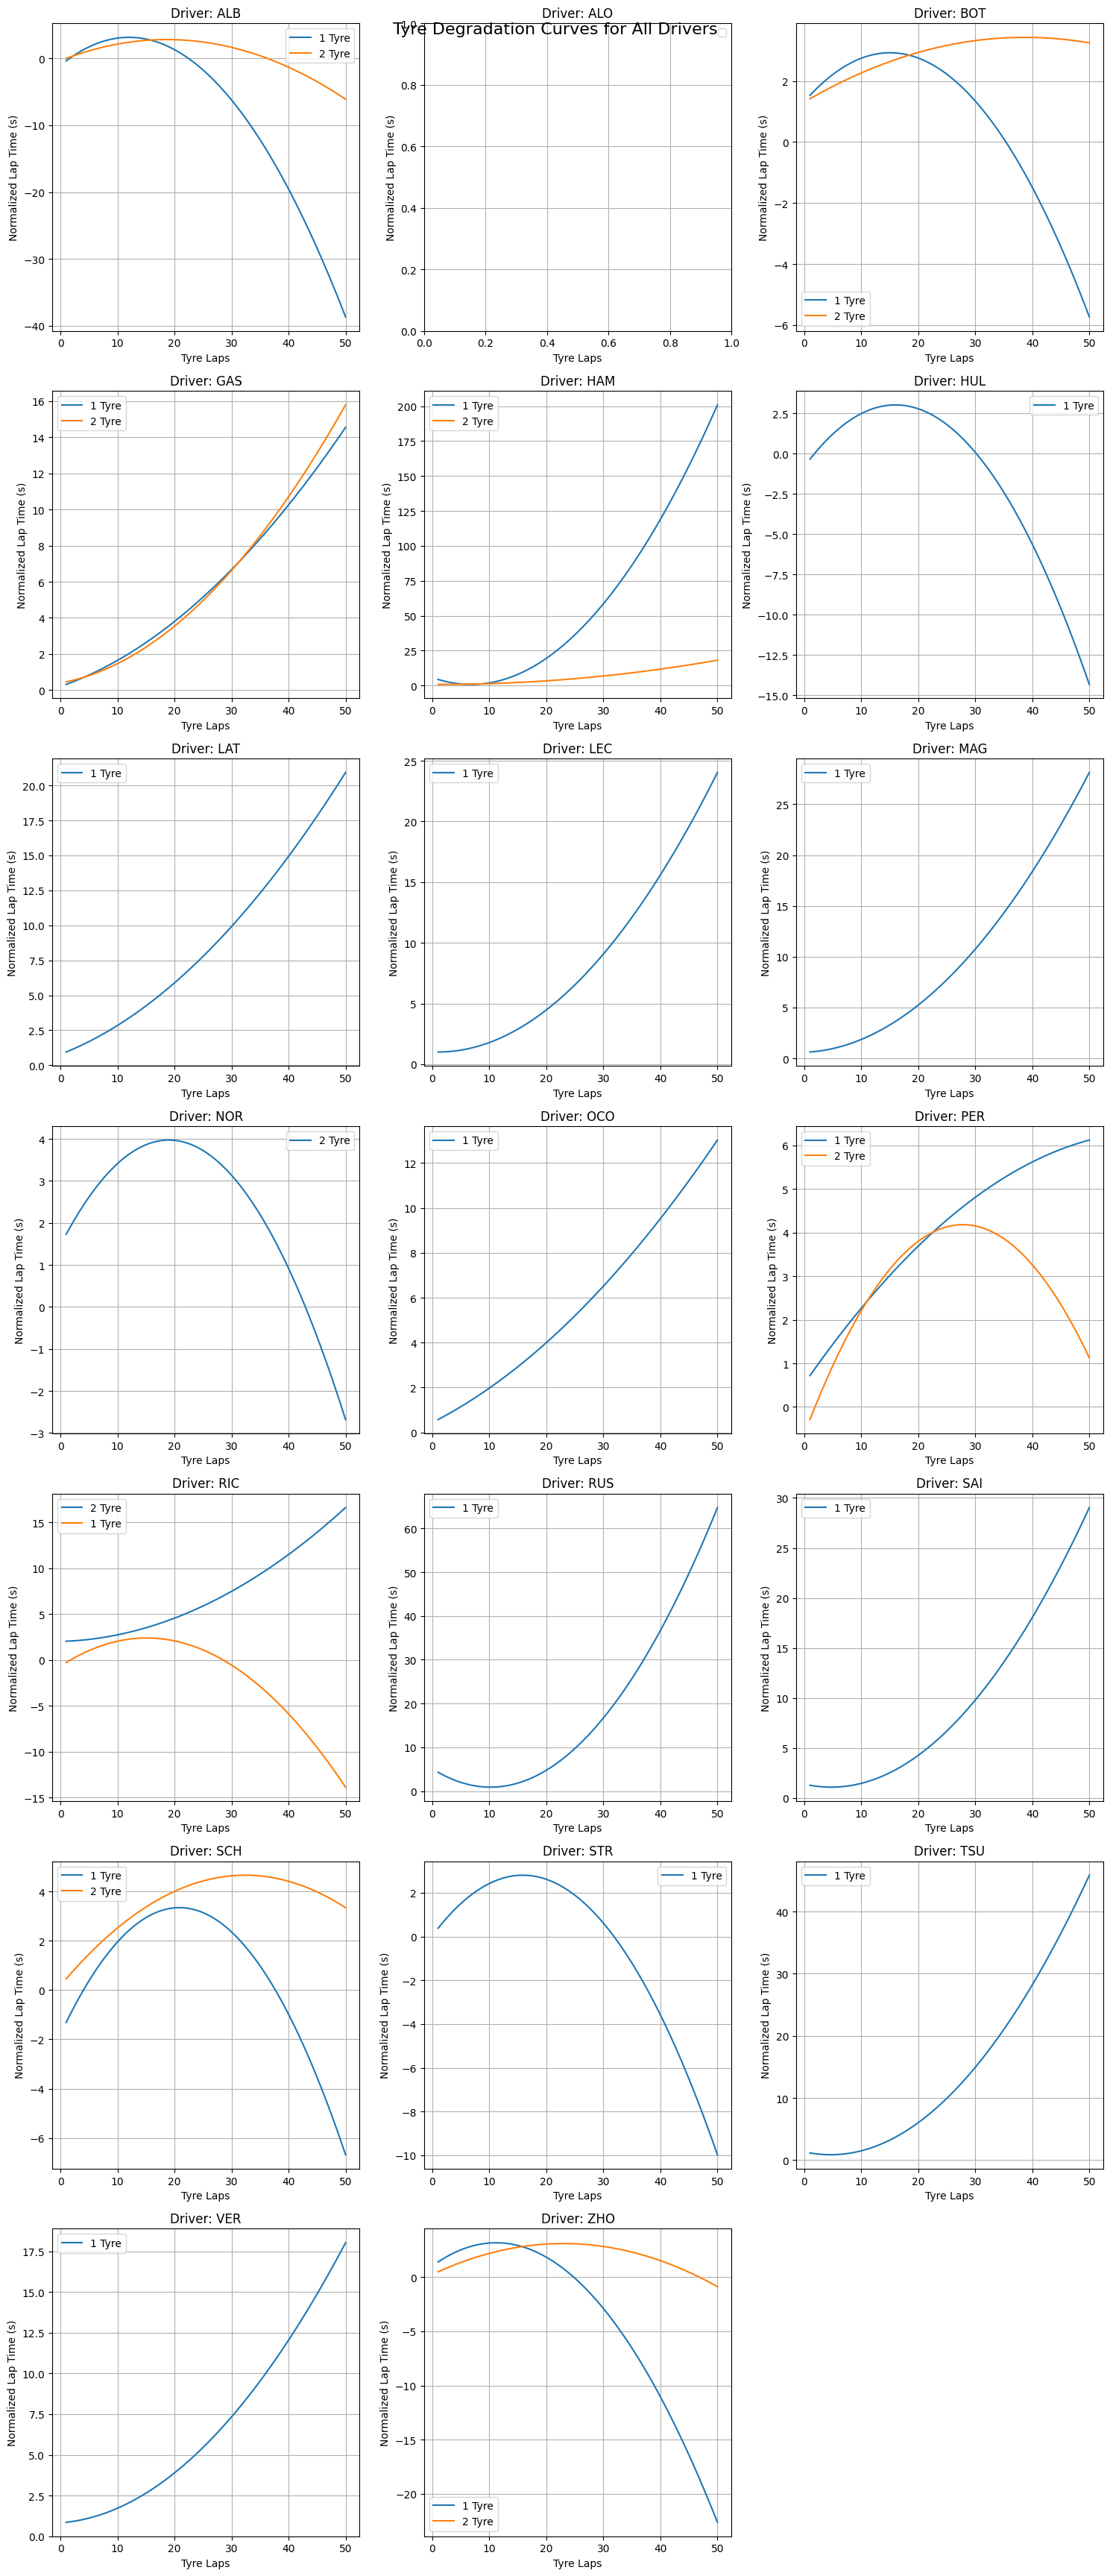

In [173]:
import matplotlib.pyplot as plt

def plot_tyre_degradation_curves_from_dict(degradation_curves):
	"""
	Plot tyre degradation curves for each driver using the output dictionary from
	`calculate_tyre_degradation_curves`.

	Parameters:
		degradation_curves (dict): A nested dictionary where:
								   - Key 1: Driver short code (e.g., 'ALB').
								   - Key 2: Tyre type (e.g., 'Soft', 'Medium', 'Hard').
								   - Value: A tuple of coefficients (a, b, c) for the polynomial ax^2 + bx + c.
	"""
	# Get the list of all drivers
	drivers = degradation_curves.keys()

	# Create a grid of subplots
	num_drivers = len(drivers)
	num_cols = 3  # Number of columns in the grid
	num_rows = (num_drivers + num_cols - 1) // num_cols  # Calculate rows needed

	fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
	fig.suptitle('Tyre Degradation Curves for All Drivers', fontsize=16)

	# Flatten the axes array for easy iteration
	axes = axes.flatten()

	# Plot curves for each driver
	for i, driver in enumerate(drivers):
		ax = axes[i]
		tyre_data = degradation_curves[driver]

		# Generate x values for plotting
		x_vals = np.linspace(1, 50, 100)  # Assume a maximum of 50 tyre laps for plotting

		# Plot curves for each tyre type
		for tyre, coefficients in tyre_data.items():
			if tyre == 4 or tyre == 5:
				continue
			a, b, c = coefficients
			y_vals = a * x_vals**2 + b * x_vals + c  # Calculate y values using the polynomial
			ax.plot(x_vals, y_vals, label=f'{tyre} Tyre')

		# Add labels and title for the subplot
		ax.set_xlabel('Tyre Laps')
		ax.set_ylabel('Normalized Lap Time (s)')
		ax.set_title(f'Driver: {driver}')
		ax.grid(True)
		ax.legend()

	# Hide unused subplots
	for j in range(i + 1, num_rows * num_cols):
		axes[j].axis('off')

	plt.tight_layout()
	plt.show()
	
plot_tyre_degradation_curves_from_dict(degradation_curves)

## Step 6) Average over whole season

Processing round 1...
Skipping stint for ALB on 1 tyres: Only 9 laps (minimum 10 required).
Skipping stint for ALB on 2 tyres: Only 7 laps (minimum 15 required).
Skipping stint for ALO on 1 tyres: Only 9 laps (minimum 10 required).
Skipping stint for ALO on 1 tyres: Only 8 laps (minimum 10 required).
Skipping stint for ALO on 2 tyres: Only 12 laps (minimum 15 required).
Skipping stint for ALO on 3 tyres: Only 15 laps (minimum 23 required).
Skipping stint for BOT on 1 tyres: Only 7 laps (minimum 10 required).
Skipping stint for BOT on 2 tyres: Only 7 laps (minimum 15 required).
Skipping stint for GAS on 3 tyres: Only 11 laps (minimum 23 required).
Skipping stint for HAM on 1 tyres: Only 7 laps (minimum 10 required).
Skipping stint for HAM on 3 tyres: Only 14 laps (minimum 23 required).
Skipping stint for HUL on 1 tyres: Only 9 laps (minimum 10 required).
Skipping stint for HUL on 2 tyres: Only 5 laps (minimum 15 required).
Skipping stint for LAT on 1 tyres: Only 9 laps (minimum 10 requi

/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_14389/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)
/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGro

Skipping stint for ALB on 2 tyres: Only 11 laps (minimum 15 required).
Skipping stint for ALO on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for ALO on 3 tyres: Only 15 laps (minimum 23 required).
Skipping stint for BOT on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for BOT on 3 tyres: Only 15 laps (minimum 23 required).
Skipping stint for GAS on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for HAM on 2 tyres: Only 9 laps (minimum 15 required).
Skipping stint for HUL on 2 tyres: Only 10 laps (minimum 15 required).
Skipping stint for LAT on 2 tyres: Only 13 laps (minimum 15 required).
Skipping stint for MAG on 2 tyres: Only 10 laps (minimum 15 required).
Skipping stint for NOR on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for PER on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for RIC on 2 tyres: Only 7 laps (minimum 15 required).
Skipping stint for RIC on 3 tyres: Only 21 laps (minimum 23 required).
Skipping

/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_14389/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Skipping stint for LAT on 3 tyres: Only 8 laps (minimum 23 required).
Skipping stint for NOR on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for OCO on 2 tyres: Only 11 laps (minimum 15 required).
Skipping stint for PER on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for SAI on 3 tyres: Only 1 laps (minimum 23 required).
Skipping stint for SCH on 2 tyres: Only 8 laps (minimum 15 required).
Skipping stint for STR on 3 tyres: Only 1 laps (minimum 23 required).
Skipping stint for STR on 3 tyres: Only 16 laps (minimum 23 required).
Skipping stint for TSU on 2 tyres: Only 12 laps (minimum 15 required).
Skipping stint for VER on 2 tyres: Only 12 laps (minimum 15 required).
Skipping stint for VER on 3 tyres: Only 14 laps (minimum 23 required).
Skipping stint for VET on 3 tyres: Only 16 laps (minimum 23 required).
Processing round 4...


/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_14389/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)
/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGro

Skipping stint for LEC on 1 tyres: Only 2 laps (minimum 10 required).
Skipping stint for LEC on 1 tyres: Only 9 laps (minimum 10 required).
Skipping stint for RIC on 2 tyres: Only 9 laps (minimum 15 required).
Skipping stint for SCH on 1 tyres: Only 9 laps (minimum 10 required).
Processing round 5...
Skipping stint for ALB on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for ALO on 2 tyres: Only 13 laps (minimum 15 required).
Skipping stint for GAS on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for GAS on 3 tyres: Only 21 laps (minimum 23 required).
Skipping stint for MAG on 2 tyres: Only 10 laps (minimum 15 required).
Skipping stint for MAG on 2 tyres: Only 9 laps (minimum 15 required).
Skipping stint for NOR on 3 tyres: Only 20 laps (minimum 23 required).
Skipping stint for PER on 2 tyres: Only 11 laps (minimum 15 required).
Skipping stint for PER on 3 tyres: Only 12 laps (minimum 23 required).
Skipping stint for RIC on 3 tyres: Only 8 laps (minimum 23 r

/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_14389/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Skipping stint for PER on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for RIC on 1 tyres: Only 9 laps (minimum 10 required).
Skipping stint for RUS on 2 tyres: Only 13 laps (minimum 15 required).
Skipping stint for SAI on 1 tyres: Only 7 laps (minimum 10 required).
Skipping stint for SAI on 2 tyres: Only 12 laps (minimum 15 required).
Skipping stint for TSU on 1 tyres: Only 9 laps (minimum 10 required).
Skipping stint for VER on 2 tyres: Only 13 laps (minimum 15 required).
Skipping stint for ZHO on 1 tyres: Only 8 laps (minimum 10 required).
Processing round 7...
Skipping stint for GAS on 3 tyres: Only 1 laps (minimum 23 required).
Skipping stint for HAM on 3 tyres: Only 1 laps (minimum 23 required).
Skipping stint for NOR on 3 tyres: Only 14 laps (minimum 23 required).
Skipping stint for NOR on 2 tyres: Only 11 laps (minimum 15 required).
Skipping stint for RUS on 3 tyres: Only 1 laps (minimum 23 required).
Skipping stint for SCH on 3 tyres: Only 2 laps (minimum 23 req

/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_14389/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)
/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGro

Skipping stint for TSU on 1 tyres: Only 5 laps (minimum 10 required).
Skipping stint for ZHO on 3 tyres: Only 1 laps (minimum 23 required).
Processing round 8...
Skipping stint for ALB on 2 tyres: Only 7 laps (minimum 15 required).
Skipping stint for ALB on 3 tyres: Only 18 laps (minimum 23 required).
Skipping stint for ALB on 3 tyres: Only 18 laps (minimum 23 required).
Skipping stint for ALO on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for GAS on 2 tyres: Only 7 laps (minimum 15 required).
Skipping stint for HAM on 2 tyres: Only 7 laps (minimum 15 required).
Skipping stint for LAT on 2 tyres: Only 1 laps (minimum 15 required).
Skipping stint for LAT on 2 tyres: Only 11 laps (minimum 15 required).
Skipping stint for LEC on 2 tyres: Only 8 laps (minimum 15 required).
Skipping stint for LEC on 3 tyres: Only 9 laps (minimum 23 required).
Skipping stint for MAG on 2 tyres: Only 7 laps (minimum 15 required).
Skipping stint for MAG on 3 tyres: Only 21 laps (minimum 23 requ

/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_14389/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)
/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGro

Skipping stint for ALB on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for ALB on 3 tyres: Only 16 laps (minimum 23 required).
Skipping stint for ALO on 3 tyres: Only 19 laps (minimum 23 required).
Skipping stint for GAS on 2 tyres: Only 2 laps (minimum 15 required).
Skipping stint for HAM on 2 tyres: Only 7 laps (minimum 15 required).
Skipping stint for HAM on 3 tyres: Only 20 laps (minimum 23 required).
Skipping stint for LAT on 2 tyres: Only 6 laps (minimum 15 required).
Skipping stint for MAG on 2 tyres: Only 5 laps (minimum 15 required).
Skipping stint for NOR on 3 tyres: Only 15 laps (minimum 23 required).
Skipping stint for NOR on 3 tyres: Only 21 laps (minimum 23 required).
Skipping stint for PER on 3 tyres: Only 6 laps (minimum 23 required).
Skipping stint for RIC on 3 tyres: Only 16 laps (minimum 23 required).
Skipping stint for RUS on 3 tyres: Only 18 laps (minimum 23 required).
Skipping stint for SAI on 3 tyres: Only 16 laps (minimum 23 required).
Skipping st

/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_14389/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)
/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGro

Skipping stint for ALB on 2 tyres: Only 9 laps (minimum 15 required).
Skipping stint for ALO on 2 tyres: Only 11 laps (minimum 15 required).
Skipping stint for BOT on 2 tyres: Only 4 laps (minimum 15 required).
Skipping stint for GAS on 2 tyres: Only 10 laps (minimum 15 required).
Skipping stint for LAT on 2 tyres: Only 10 laps (minimum 15 required).
Skipping stint for LAT on 3 tyres: Only 20 laps (minimum 23 required).
Skipping stint for LAT on 3 tyres: Only 9 laps (minimum 23 required).
Skipping stint for LEC on 2 tyres: Only 12 laps (minimum 15 required).
Skipping stint for LEC on 3 tyres: Only 20 laps (minimum 23 required).
Skipping stint for LEC on 3 tyres: Only 7 laps (minimum 23 required).
Skipping stint for MAG on 2 tyres: Only 13 laps (minimum 15 required).
Skipping stint for NOR on 2 tyres: Only 12 laps (minimum 15 required).
Skipping stint for NOR on 3 tyres: Only 22 laps (minimum 23 required).
Skipping stint for OCO on 2 tyres: Only 14 laps (minimum 15 required).
Skipping s

/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_14389/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)
/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGro

Skipping stint for LAT on 1 tyres: Only 8 laps (minimum 10 required).
Skipping stint for LEC on 3 tyres: Only 13 laps (minimum 23 required).
Skipping stint for MAG on 2 tyres: Only 4 laps (minimum 15 required).
Skipping stint for NOR on 1 tyres: Only 9 laps (minimum 10 required).
Skipping stint for RIC on 3 tyres: Only 18 laps (minimum 23 required).
Skipping stint for SAI on 2 tyres: Only 13 laps (minimum 15 required).
Skipping stint for SCH on 3 tyres: Only 17 laps (minimum 23 required).
Skipping stint for TSU on 1 tyres: Only 8 laps (minimum 10 required).
Skipping stint for ZHO on 3 tyres: Only 18 laps (minimum 23 required).
Processing round 14...
Skipping stint for ALB on 2 tyres: Only 5 laps (minimum 15 required).
Skipping stint for ALB on 3 tyres: Only 14 laps (minimum 23 required).
Skipping stint for ALO on 2 tyres: Only 7 laps (minimum 15 required).
Skipping stint for ALO on 2 tyres: Only 12 laps (minimum 15 required).
Skipping stint for ALO on 3 tyres: Only 18 laps (minimum 23 

/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_14389/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Skipping stint for ALB on 3 tyres: Only 8 laps (minimum 23 required).
Skipping stint for ALO on 1 tyres: Only 6 laps (minimum 10 required).
Skipping stint for BOT on 2 tyres: Only 13 laps (minimum 15 required).
Skipping stint for GAS on 1 tyres: Only 9 laps (minimum 10 required).
Skipping stint for GAS on 3 tyres: Only 18 laps (minimum 23 required).
Skipping stint for HAM on 2 tyres: Only 5 laps (minimum 15 required).
Skipping stint for HAM on 2 tyres: Only 12 laps (minimum 15 required).
Skipping stint for HAM on 3 tyres: Only 17 laps (minimum 23 required).
Skipping stint for LAT on 2 tyres: Only 12 laps (minimum 15 required).
Skipping stint for LAT on 3 tyres: Only 22 laps (minimum 23 required).
Skipping stint for LEC on 3 tyres: Only 6 laps (minimum 23 required).
Skipping stint for MAG on 2 tyres: Only 11 laps (minimum 15 required).
Skipping stint for MAG on 3 tyres: Only 10 laps (minimum 23 required).
Skipping stint for MAG on 1 tyres: Only 6 laps (minimum 10 required).
Skipping sti

/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_14389/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)
/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGro

Skipping stint for LAT on 2 tyres: Only 12 laps (minimum 15 required).
Skipping stint for MAG on 3 tyres: Only 20 laps (minimum 23 required).
Skipping stint for MAG on 1 tyres: Only 1 laps (minimum 10 required).
Skipping stint for NOR on 1 tyres: Only 1 laps (minimum 10 required).
Skipping stint for PER on 2 tyres: Only 5 laps (minimum 15 required).
Skipping stint for PER on 1 tyres: Only 3 laps (minimum 10 required).
Skipping stint for RUS on 3 tyres: Only 22 laps (minimum 23 required).
Skipping stint for STR on 3 tyres: Only 19 laps (minimum 23 required).
Skipping stint for VET on 2 tyres: Only 9 laps (minimum 15 required).
Processing round 17...
Skipping stint for RUS on 1 tyres: Only 3 laps (minimum 10 required).
Skipping stint for RUS on 1 tyres: Only 3 laps (minimum 10 required).
Processing round 18...


/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_14389/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)
/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGro

Processing round 19...
Skipping stint for ALB on 2 tyres: Only 8 laps (minimum 15 required).
Skipping stint for ALB on 2 tyres: Only 7 laps (minimum 15 required).
Skipping stint for BOT on 2 tyres: Only 9 laps (minimum 15 required).
Skipping stint for BOT on 3 tyres: Only 5 laps (minimum 23 required).
Skipping stint for GAS on 2 tyres: Only 11 laps (minimum 15 required).
Skipping stint for GAS on 3 tyres: Only 12 laps (minimum 23 required).
Skipping stint for HAM on 2 tyres: Only 12 laps (minimum 15 required).
Skipping stint for HAM on 3 tyres: Only 13 laps (minimum 23 required).
Skipping stint for HAM on 3 tyres: Only 21 laps (minimum 23 required).
Skipping stint for LAT on 2 tyres: Only 3 laps (minimum 15 required).
Skipping stint for LAT on 2 tyres: Only 11 laps (minimum 15 required).
Skipping stint for LEC on 3 tyres: Only 10 laps (minimum 23 required).
Skipping stint for MAG on 3 tyres: Only 16 laps (minimum 23 required).
Skipping stint for NOR on 2 tyres: Only 14 laps (minimum 15

/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_14389/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Skipping stint for ALO on 3 tyres: Only 20 laps (minimum 23 required).
Skipping stint for RUS on 1 tyres: Only 1 laps (minimum 10 required).
Skipping stint for STR on 2 tyres: Only 14 laps (minimum 15 required).
Processing round 21...


/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_14389/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Skipping stint for ALO on 2 tyres: Only 6 laps (minimum 15 required).
Skipping stint for GAS on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for GAS on 2 tyres: Only 12 laps (minimum 15 required).
Skipping stint for LAT on 2 tyres: Only 13 laps (minimum 15 required).
Skipping stint for LAT on 3 tyres: Only 10 laps (minimum 23 required).
Skipping stint for LEC on 2 tyres: Only 12 laps (minimum 15 required).
Skipping stint for NOR on 1 tyres: Only 4 laps (minimum 10 required).
Skipping stint for SAI on 2 tyres: Only 10 laps (minimum 15 required).
Skipping stint for TSU on 2 tyres: Only 12 laps (minimum 15 required).
Skipping stint for TSU on 2 tyres: Only 11 laps (minimum 15 required).
Skipping stint for VER on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for ZHO on 1 tyres: Only 8 laps (minimum 10 required).
Processing round 22...


/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_14389/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Skipping stint for ALB on 2 tyres: Only 11 laps (minimum 15 required).
Skipping stint for ALB on 3 tyres: Only 22 laps (minimum 23 required).
Skipping stint for ALO on 3 tyres: Only 7 laps (minimum 23 required).
Skipping stint for LAT on 2 tyres: Only 13 laps (minimum 15 required).
Skipping stint for LAT on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for LAT on 3 tyres: Only 21 laps (minimum 23 required).
Skipping stint for NOR on 2 tyres: Only 13 laps (minimum 15 required).
Skipping stint for OCO on 2 tyres: Only 13 laps (minimum 15 required).
Skipping stint for OCO on 3 tyres: Only 16 laps (minimum 23 required).
Skipping stint for PER on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for PER on 3 tyres: Only 17 laps (minimum 23 required).
Skipping stint for RUS on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for SAI on 3 tyres: Only 21 laps (minimum 23 required).
Skipping stint for SAI on 3 tyres: Only 18 laps (minimum 23 required).
Skippin

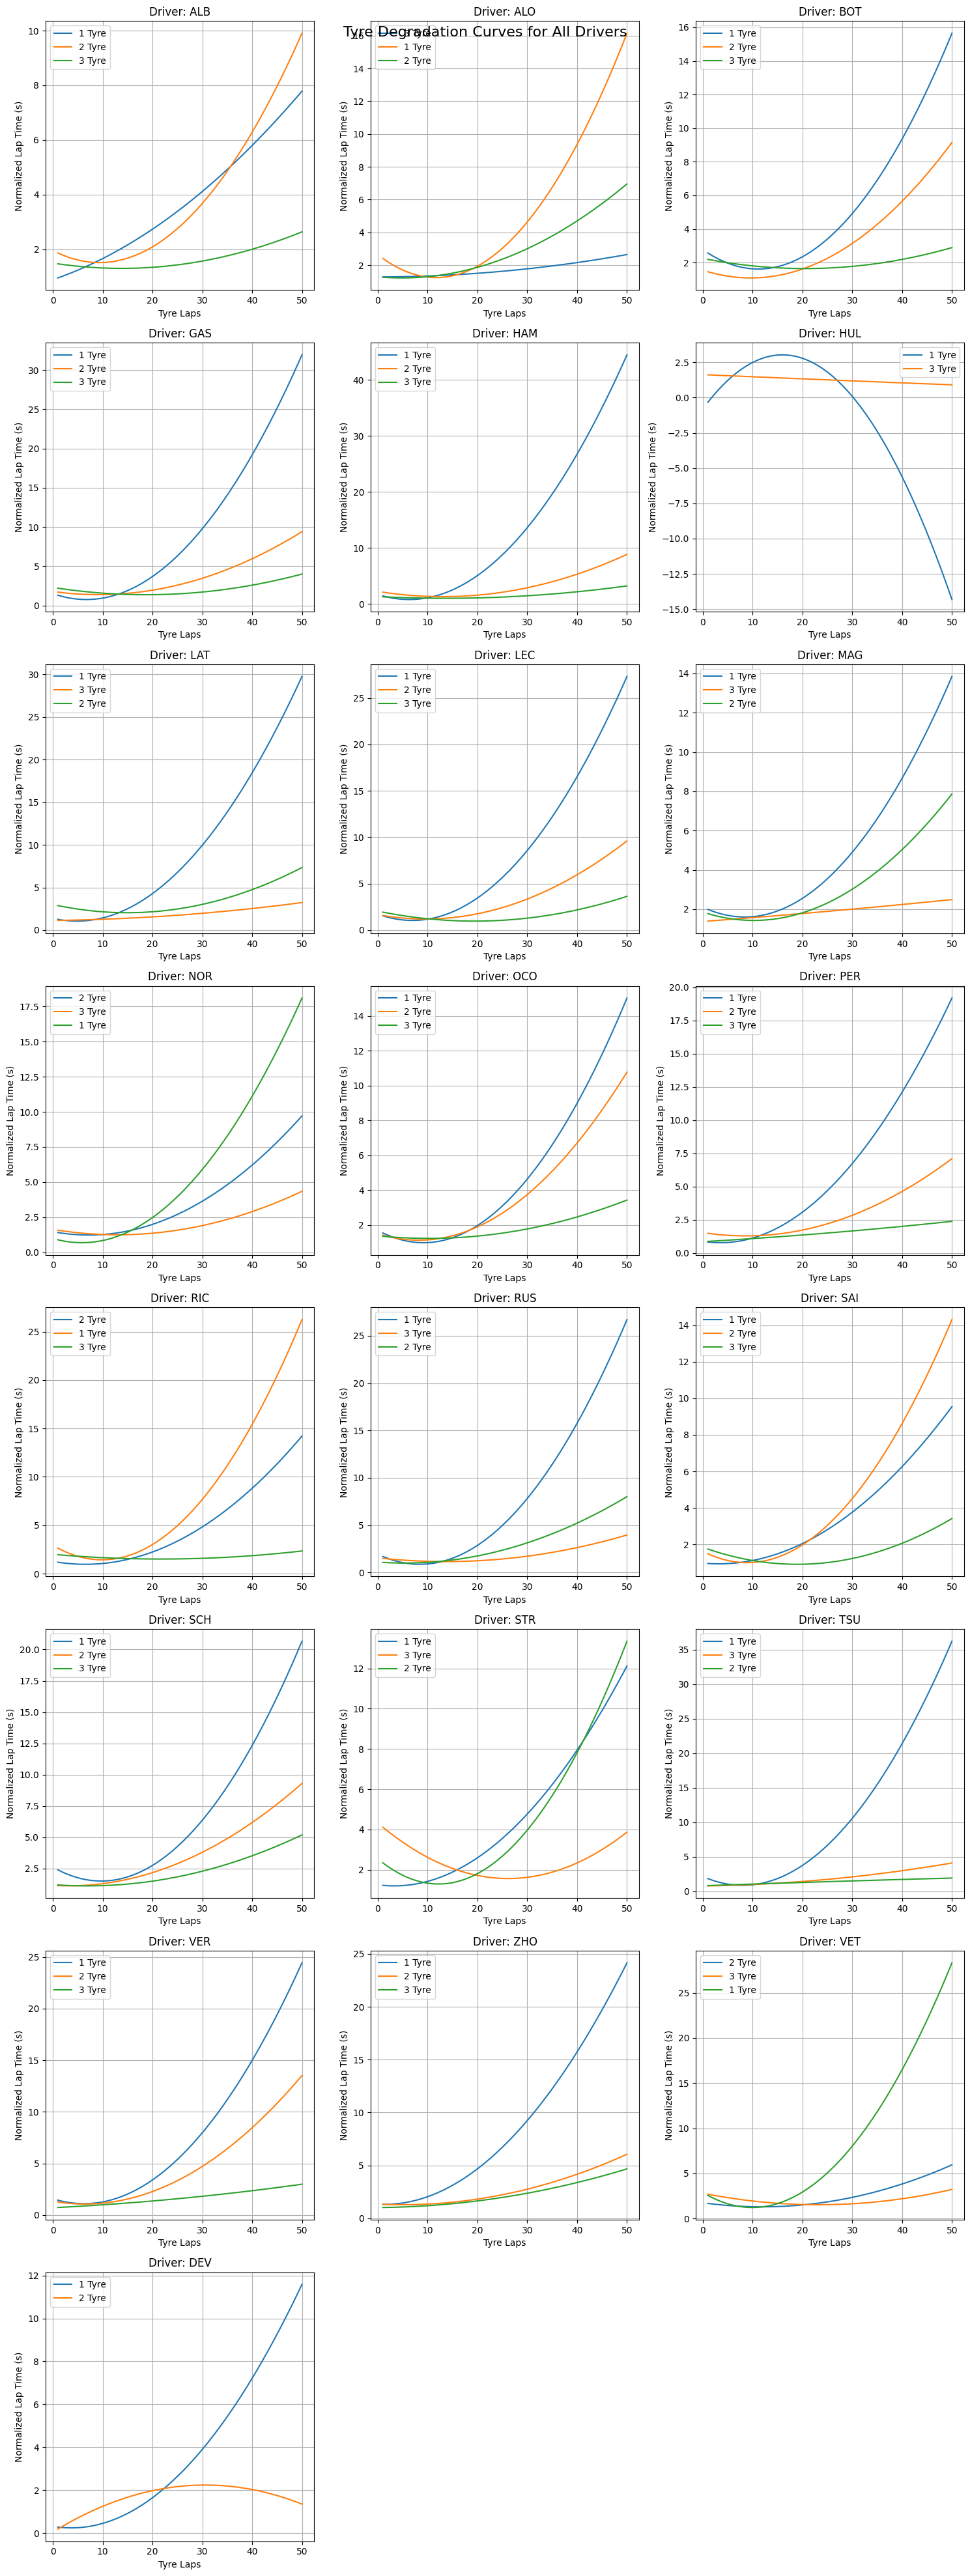

In [174]:
# Step 1: Load all 2022 data (remove round filter)
df_full_season = create_dataframe()
df_full_season = df_full_season[df_full_season['year'] == 2022]

# Step 2: Initialize storage for aggregated coefficients
all_season_curves = {}

# Get list of all rounds in 2022
all_rounds = df_full_season['round'].unique()

# Step 3: Process each race
for race_round in all_rounds:
	print(f"Processing round {race_round}...")
	
	# Filter race data
	df_race = df_full_season[df_full_season['round'] == race_round]
	df_race = df_race[df_race['session_type'] == 'Race']
	
	# Skip if no race data
	if df_race.empty:
		continue
		
	# Process pipeline
	try:
		df_race = assign_stint_numbers(df_race)
		df_race = correct_fuel_effect(df_race)
		df_race = remove_laps_outside_percent(df_race)
		df_race = normalise_lap_times(df_race)
		
		# Get degradation curves for this race
		race_curves = calculate_tyre_degradation_curves(df_race)
		
		# Aggregate results
		for driver, tyre_data in race_curves.items():
			if driver not in all_season_curves:
				all_season_curves[driver] = {}
				
			for tyre, coeffs in tyre_data.items():
				if tyre not in all_season_curves[driver]:
					all_season_curves[driver][tyre] = []
				all_season_curves[driver][tyre].append(coeffs)
				
	except Exception as e:
		print(f"Error processing round {race_round}: {str(e)}")
		continue

# Step 4: Average coefficients across all races
averaged_season_curves = {}
for driver, tyre_data in all_season_curves.items():
	averaged_season_curves[driver] = {}
	
	for tyre, coeff_list in tyre_data.items():
		# Convert list of coefficient arrays to 2D array
		coeff_array = np.array(coeff_list)
		
		# Calculate mean coefficients (ignore NaN values)
		mean_coeffs = np.nanmean(coeff_array, axis=0)
		
		# Handle cases where all values might be NaN
		if np.any(np.isnan(mean_coeffs)):
			print(f"Warning: Insufficient data for {driver} on {tyre} tyres")
			continue
			
		averaged_season_curves[driver][tyre] = mean_coeffs

# Step 5: Plot averaged curves
print("\nPlotting averaged degradation curves for 2022 season:")
plot_tyre_degradation_curves_from_dict(averaged_season_curves)

## Predict times and test

In [175]:
from collections import defaultdict

tyre_coefficients = defaultdict(list)


for driver, tyre_data in averaged_season_curves.items():
	for tyre, coefficients in tyre_data.items():
		tyre_coefficients[tyre].append(coefficients)

# Calculate average coefficients for each tyre
averaged_tyre_curves = {}
for tyre, coeff_list in tyre_coefficients.items():
	coeff_array = np.array(coeff_list)
	mean_coeffs = np.mean(coeff_array, axis=0)  # Average across drivers
	averaged_tyre_curves[tyre] = mean_coeffs

print(averaged_tyre_curves)

{np.int64(1): array([ 0.01008368, -0.13204467,  1.61152705]), np.int64(2): array([ 0.0043085 , -0.07088103,  1.56229384]), np.int64(3): array([ 1.52898604e-03, -4.34564622e-02,  1.66298661e+00]), np.int64(4): array([0.01352714, 0.10173257, 1.19763494]), np.int64(5): array([ 0.16125325, -5.13236824, 41.90583387])}


In [ ]:
# Load 2023 data for the first 10 races
df_2023 = create_dataframe()
df_2023 = df_2023[(df_2023['year'] == 2023) & (df_2023['round'].between(1, 10))]


all_rounds = df_2023['round'].unique()

total_total_absolute_error = 0
total_total_squared_error = 0
total_mae = 0
total_rmse = 0

for race_round in all_rounds:
	print(f"Processing round {race_round}...")
	
	# Filter race data
	df_race = df_full_season[df_full_season['round'] == race_round]
	df_race = df_race[df_race['session_type'] == 'Race']
	
	# Skip if no race data
	if df_race.empty:
		continue
		

	df_race = assign_stint_numbers(df_race)
	df_race = correct_fuel_effect(df_race)
	# df_race = remove_laps_outside_percent(df_race)
	df_race = normalise_lap_times(df_race)

		


	# Initialize columns for predictions and errors
	df_race['predicted_normalized'] = np.nan
	df_race['error'] = np.nan
	df_race['absolute_error'] = np.nan
	df_race['squared_error'] = np.nan

	for index, row in df_race.iterrows():
		driver = row['driver_short']
		tyre = row['tyre']
		tyre_laps = row['tyre_laps']
		actual = row['normalised_lap_time']
		
		if driver not in averaged_season_curves or tyre not in averaged_season_curves[driver]:
			continue  # Skip if no data
		
		a, b, c = averaged_season_curves[driver][tyre]
		# a, b, c = averaged_tyre_curves[tyre]

		averaged_tyre_curves
		predicted = a * (tyre_laps ** 2) + b * tyre_laps + c
		
		error = actual - predicted
		df_race.at[index, 'predicted_normalized'] = predicted
		df_race.at[index, 'error'] = error
		df_race.at[index, 'absolute_error'] = abs(error)
		df_race.at[index, 'squared_error'] = error ** 2
	

	# Total errors
	total_absolute_error = df_race['absolute_error'].sum()
	total_squared_error = df_race['squared_error'].sum()
	mae = df_race['absolute_error'].mean()
	rmse = np.sqrt(df_race['squared_error'].mean())

	total_total_absolute_error += total_absolute_error
	total_total_squared_error += total_squared_error
	total_mae += mae
	total_rmse += rmse

	# print(f"\n\n Race {race_round}:")
	# print(f"Total Absolute Error: {total_absolute_error:.4f}")
	# print(f"Total Squared Error: {total_squared_error:.4f}")
	# print(f"MAE: {mae:.4f}")
	# print(f"RMSE: {rmse:.4f}")

print(f"\n\nTOTALS:\n\n")

print(f"Total Absolute Error: {total_total_absolute_error:.4f}")
print(f"Total Squared Error: {total_total_squared_error:.4f}")
print(f"MAE: {total_mae:.4f}")
print(f"RMSE: {total_rmse:.4f}")

Processing round 1...


/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)


Processing round 2...
Processing round 3...


/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)


Processing round 4...


/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)


Processing round 5...


/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)


Processing round 6...


/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)


Processing round 7...


/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)


Processing round 8...


/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)


Processing round 9...


/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)


Processing round 10...


TOTALS:


Total Absolute Error: 55819.5035
Total Squared Error: 1751205.4856
MAE: 53.2067
RMSE: 122.3050


/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)


TOTALS:


Total Absolute Error: 55818.4723
Total Squared Error: 1750306.3801
MAE: 53.2083
RMSE: 122.2611


TOTALS:


Total Absolute Error: 55579.7671
Total Squared Error: 1744015.3450
MAE: 53.0035
RMSE: 122.1162

Processing round 1...


/tmp/ipykernel_14389/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_14389/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


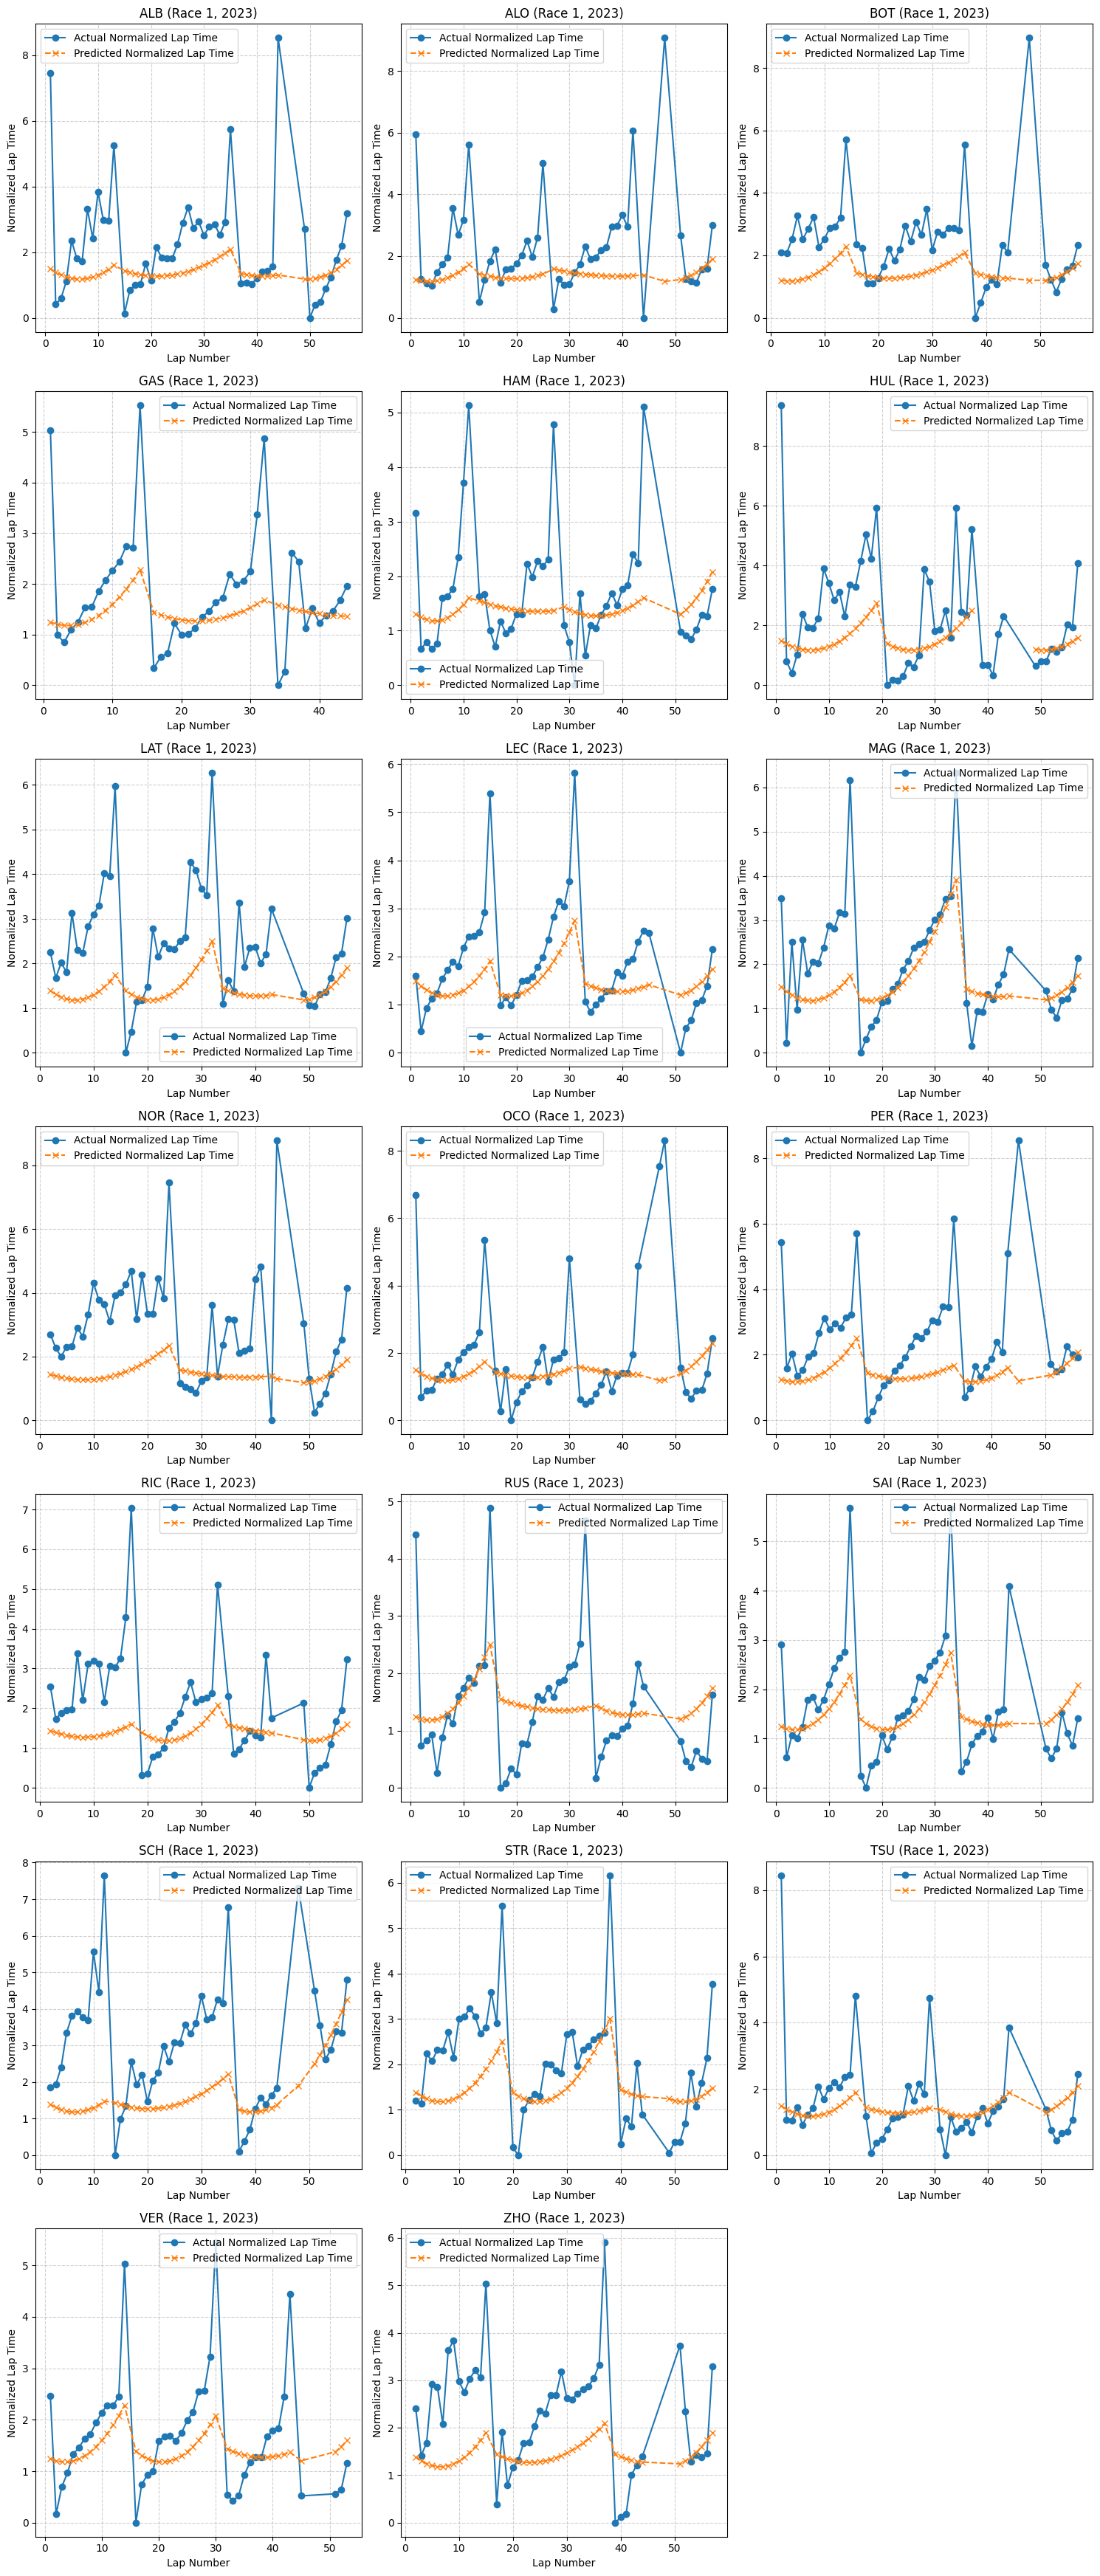



TOTALS:


Total Absolute Error: 969.3384
Total Squared Error: 2166.9197
MAE: 1.0003
RMSE: 1.4954

Absolute Errors for Top Drivers:
VER: 33.0586
HAM: 35.8790
LEC: 32.1133
SAI: 32.8608
RUS: 34.2650


In [186]:
import math
import matplotlib.pyplot as plt

# Load 2023 data for the first 10 races
df_2023 = create_dataframe()
df_2023 = df_2023[(df_2023['year'] == 2023) & (df_2023['round'].between(1, 1))]

all_rounds = df_2023['round'].unique()

total_total_absolute_error = 0
total_total_squared_error = 0
total_mae = 0
total_rmse = 0

# Drivers of interest
top_drivers = ['VER', 'HAM', 'LEC', 'SAI', 'RUS']
driver_errors = {driver: 0 for driver in top_drivers}

for race_round in all_rounds:
    print(f"Processing round {race_round}...")
    
    # Filter race data
    df_race = df_full_season[df_full_season['round'] == race_round]
    df_race = df_race[df_race['session_type'] == 'Race']
    
    # Skip if no race data
    if df_race.empty:
        continue

    df_race = assign_stint_numbers(df_race)
    df_race = correct_fuel_effect(df_race)
    df_race = remove_laps_outside_percent(df_race, percentage=10)
    df_race = normalise_lap_times(df_race)

    # Initialize columns for predictions and errors
    df_race['predicted_normalized'] = np.nan
    df_race['error'] = np.nan
    df_race['absolute_error'] = np.nan
    df_race['squared_error'] = np.nan

    for index, row in df_race.iterrows():
        driver = row['driver_short']
        tyre = row['tyre']
        tyre_laps = row['tyre_laps']
        actual = row['normalised_lap_time']
        
        if driver not in averaged_season_curves or tyre not in averaged_season_curves[driver]:
            continue  # Skip if no data
        
        # a, b, c = averaged_season_curves[driver][tyre]
        a, b, c = averaged_tyre_curves[tyre]
        predicted = a * (tyre_laps ** 2) + b * tyre_laps + c
        
        error = actual - predicted
        df_race.at[index, 'predicted_normalized'] = predicted
        df_race.at[index, 'error'] = error
        df_race.at[index, 'absolute_error'] = abs(error)
        df_race.at[index, 'squared_error'] = error ** 2

    # Total errors
    total_absolute_error = df_race['absolute_error'].sum()
    total_squared_error = df_race['squared_error'].sum()
    mae = df_race['absolute_error'].mean()
    rmse = np.sqrt(df_race['squared_error'].mean())

    total_total_absolute_error += total_absolute_error
    total_total_squared_error += total_squared_error
    total_mae += mae
    total_rmse += rmse

    # Calculate total absolute error for specific drivers
    for driver in top_drivers:
        driver_error = df_race[df_race['driver_short'] == driver]['absolute_error'].sum()
        driver_errors[driver] += driver_error

    # Generate plots for all drivers
    drivers_race1 = df_race['driver_short'].unique()
    num_drivers = len(drivers_race1)
    cols = 3  # Number of columns in the grid
    rows = math.ceil(num_drivers / cols)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, driver in enumerate(drivers_race1):
        driver_data = df_race[df_race['driver_short'] == driver]
        
        ax = axes[i]
        ax.plot(
            driver_data['lap_num'],
            driver_data['normalised_lap_time'],
            label="Actual Normalized Lap Time",
            marker="o",
            linestyle="-",
        )
        ax.plot(
            driver_data['lap_num'],
            driver_data['predicted_normalized'],
            label="Predicted Normalized Lap Time",
            marker="x",
            linestyle="--",
        )
        
        ax.set_title(f"{driver} (Race {race_round}, 2023)")
        ax.set_xlabel("Lap Number")
        ax.set_ylabel("Normalized Lap Time")
        ax.legend()
        ax.grid(True, linestyle="--", alpha=0.6)

    # Turn off unused subplots
    for j in range(len(drivers_race1), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

print(f"\n\nTOTALS:\n\n")
print(f"Total Absolute Error: {total_total_absolute_error:.4f}")
print(f"Total Squared Error: {total_total_squared_error:.4f}")
print(f"MAE: {total_mae:.4f}")
print(f"RMSE: {total_rmse:.4f}")

# Print individual absolute errors for each top driver
print("\nAbsolute Errors for Top Drivers:")
for driver, error in driver_errors.items():
    print(f"{driver}: {error:.4f}")


TOTALS:


Total Absolute Error: 967.4105
Total Squared Error: 2154.7322
MAE: 0.9984
RMSE: 1.4912

Absolute Errors for Top Drivers:
VER: 31.6190
HAM: 41.1550
LEC: 32.5351
SAI: 36.8951
RUS: 32.5789


TOTALS:


Total Absolute Error: 969.3384
Total Squared Error: 2166.9197
MAE: 1.0003
RMSE: 1.4954

Absolute Errors for Top Drivers:
VER: 33.0586
HAM: 35.8790
LEC: 32.1133
SAI: 32.8608
RUS: 34.2650